## Setup

In [1]:
import deeptrack as DT
import imageGeneration as IG
import benchmark
import unet
import cv2
import numpy as np

In [2]:
#bugfix for fredrik REMOVE LATER
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], False)

## Generate images using our method

In [3]:
def get_image_parameters_preconfig(image_size=256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    

    particle_number = randint(2, 5)
    particle_radius_list = uniform(5, 10, particle_number)
    (particle_center_x_list, particle_center_y_list) = IG.get_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.3, 0.5, 1), ])

    image_parameters = IG.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.2, .5),
        signal_to_noise_ratio=lambda: uniform(5,100),
        gradient_intensity=lambda: uniform(0, 0.1),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters


get_image_parameters_function=lambda: get_image_parameters_preconfig(image_size = 51)


batch_images,batch_labels,batch_predictions, particle_positions_and_radiuses = IG.get_batch(get_image_parameters_function = get_image_parameters_function,batch_size=10, include_particle_positions_and_radiuses = True) 

number_of_images_to_save = 10

for image_number,image in enumerate(batch_images):
    if image_number>=number_of_images_to_save:
        break
    
    filepath = './images/frame{}.jpg'.format(str(image_number))
    image = image*255
    cv2.imwrite(filepath,image)

cv2.destroyAllWindows()

Time taken for batch generation of size 10: 0.09210872650146484 s.


### Construct video from images


In [4]:
import cv2
import matplotlib.pyplot as plt
import os
from os.path import isfile, join

pathIn = './images/'
pathOut = 'output.mp4'
fps = 25
size = 0
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

#for sorting the file names properly
files.sort(key = lambda x: int(x[5:-4]))

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    #inserting the frames into an image array
    frame_array.append(img)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])

out.release()
cv2.destroyAllWindows()


## Tracking and visualisation using deeptrack


In [5]:
saved_network_file_name = "DeepTrack - Example 3 - Pretrained network.h5"
dt_model = DT.load(saved_network_file_name)

video = cv2.VideoCapture("output.mp4")
(number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
 boxes_all) = DT.track_video("output.mp4", dt_model,box_half_size = 18,box_scanning_step = 3,frame_normalize = 0,frame_enhance = 1,number_frames_to_be_tracked = 0)


Using TensorFlow backend.


In [7]:
def get_predicted_positions_and_radiuses_DT(number_frames_to_be_tracked, predicted_positions_wrt_frame, particle_radial_distance_threshold):
    from numpy import sqrt,zeros
    predicted_positions_and_radiuses = []
    nr_predictions = zeros(number_frames_to_be_tracked)
    
    for i in range(number_frames_to_be_tracked):
        predictions_for_frame_i = predicted_positions_wrt_frame[i,:,:,:]
        nr_predictions[i] = predictions_for_frame_i[:,0,0].shape[0]**2
        for j in range(int(sqrt(nr_predictions[i]))):
            for k in range(int(sqrt(nr_predictions[i]))):
                if(predictions_for_frame_i[j,k,:][2] < particle_radial_distance_threshold):
                    x_position = predictions_for_frame_i[j,k,0]
                    y_position = predictions_for_frame_i[j,k,1]
                    radius = predictions_for_frame_i[j,k,2]
                    frame_index = i
                    predicted_positions_and_radiuses.append((frame_index,x_position,y_position,radius))
    
    return predicted_positions_and_radiuses

In [49]:
def hits_and_misses(number_frames_to_be_tracked, predicted_positions, particle_positions_and_radiuses, return_misses = False):
    from numpy import sqrt, zeros

    nr_predictions = zeros(number_frames_to_be_tracked)
    nr_real_particles = zeros(number_frames_to_be_tracked)
    nr_hits = zeros(number_frames_to_be_tracked)
    nr_misses = zeros(number_frames_to_be_tracked)
    misses = []


    for i in range(int(number_frames_to_be_tracked)):
        predictions_for_frame_i = []
        for j in range(len(predicted_positions)):
            if(predicted_positions[j][0] == i):
                predictions_for_frame_i.append(predicted_positions[j])
        
        nr_predictions[i] = len(predictions_for_frame_i)
        nr_real_particles[i] = len(particle_positions_and_radiuses[i][0])
        
        for j in range(int(nr_predictions[i])):
            hasHit = False
            for part in range(int(nr_real_particles[i])):
                distance_x = (predictions_for_frame_i[j][1] - particle_positions_and_radiuses[i][0][part])**2
                distance_y = (predictions_for_frame_i[j][2] - particle_positions_and_radiuses[i][1][part])**2
                distance = sqrt(distance_x + distance_y)

                if(distance < particle_positions_and_radiuses[i][2][part]):
                    hasHit = True  

            if(hasHit):nr_hits[i] += 1 
            else: misses.append(predictions_for_frame_i[j])
                        
        nr_misses[i] = nr_predictions[i] - nr_hits[i]          
    

    if(return_misses):
        return nr_real_particles,nr_predictions,nr_hits,nr_misses,misses
    else:
        return nr_real_particles,nr_predictions,nr_hits,nr_misses

In [50]:
def visualize_hits_and_misses(number_frames_to_be_tracked, frames,  particle_positions_and_radiuses, predicted_positions, misses):
    import matplotlib.pyplot as plt
    
    ### Visualize tracked frames
    for i in range(number_frames_to_be_tracked):
        
        # Show frame
        fig = plt.figure(figsize=(10, 10))
        plt.imshow(frames[i], cmap='gray', vmin=0, vmax=1)
        nr_real_particles = len(particle_positions_and_radiuses[i][0])

        # Threshold the radial distance of the predicted points
        for j in range(int(len(predicted_positions))):
            if(predicted_positions[j][0]):
                if(predicted_positions[j] in misses):
                    # Plot the predicted points
                    plt.plot(predicted_positions[j][2],
                            predicted_positions[j][1], '.r')
                else:
                    # Plot the predicted points
                    plt.plot(predicted_positions[j][2],
                            predicted_positions[j][1], '.b')
        
        for part in range(nr_real_particles):
            plt.plot(particle_positions_and_radiuses[i][1][part],
                                particle_positions_and_radiuses[i][0][part], '^m')
            circle = plt.Circle((particle_positions_and_radiuses[i][1][part], particle_positions_and_radiuses[i][0][part]), particle_positions_and_radiuses[i][2][part], color='m', fill=False)
            plt.gcf().gca().add_artist(circle)

2.0
3.0
2.0
1.0
[(0, 24.355389654636383, 4.397045731544495), (1, 24.53158313035965, 16.422962337732315), (2, 26.447392880916595, 25.844621595740318), (5, 36.890113373597465, 28.111350211004417), (6, 30.239208698272705, 13.270459842681884), (6, 33.11013567447662, 23.61807629466057), (8, 16.040240362286568, 35.381466552615166), (8, 31.246773923436802, 29.169163689017296)]


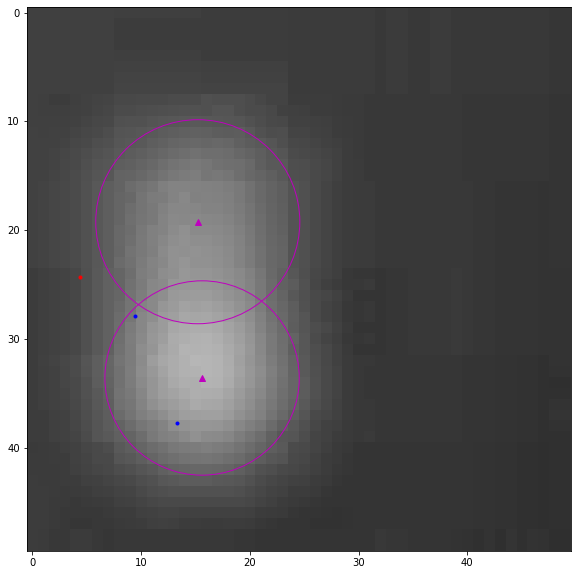

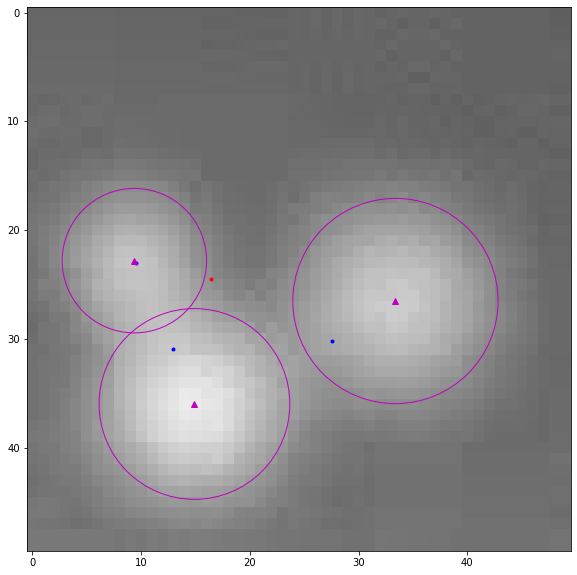

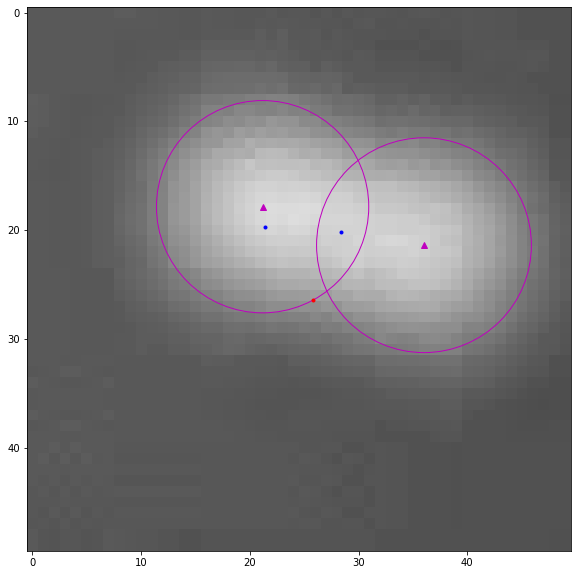

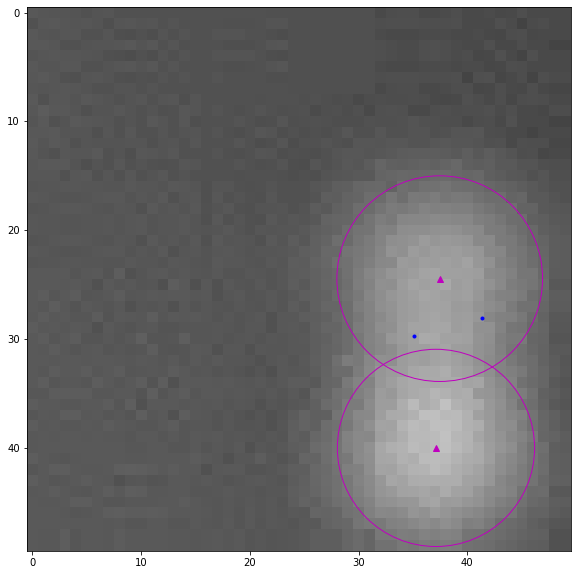

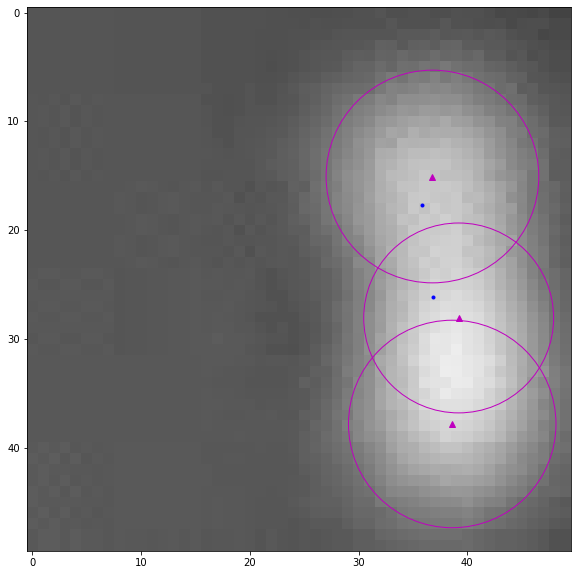

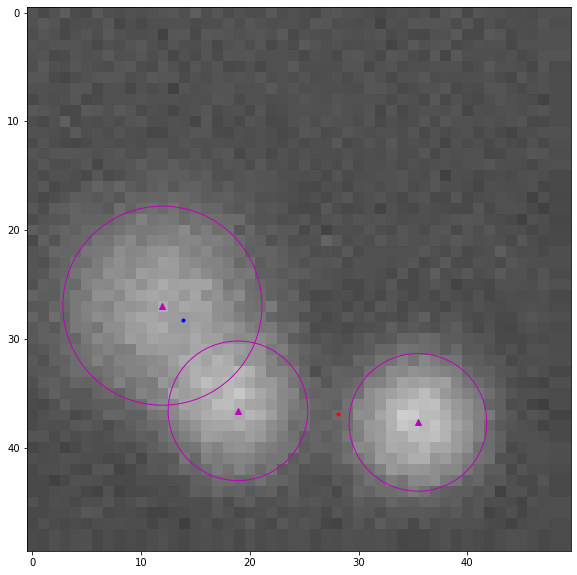

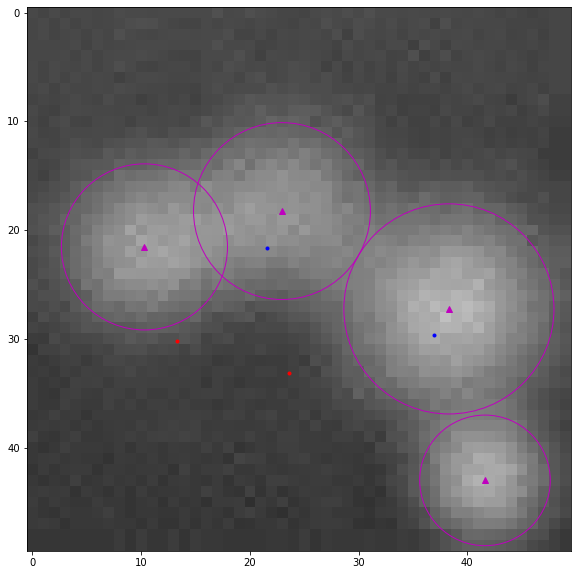

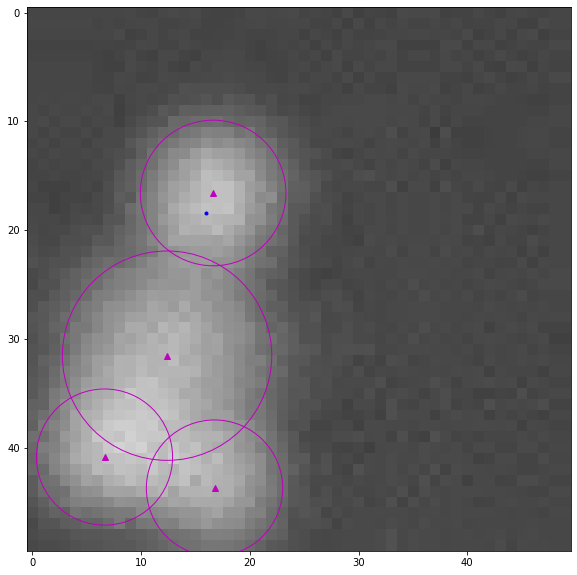

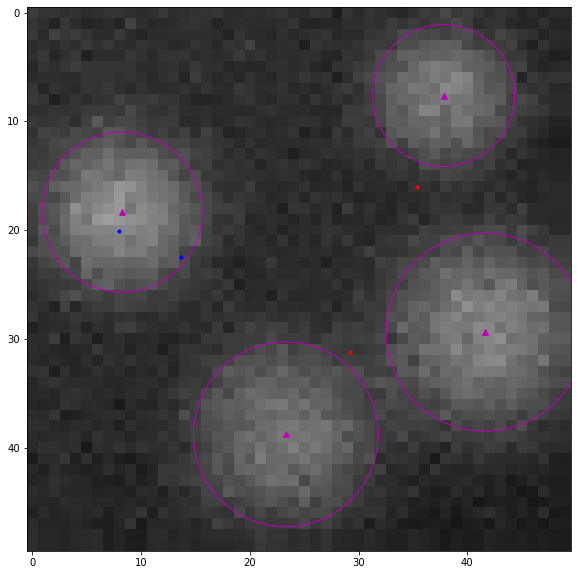

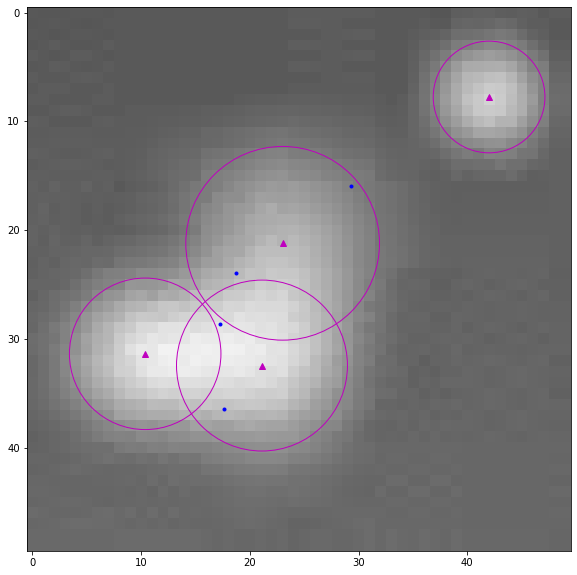

In [57]:
particle_radial_distance_threshold = 20
particle_maximum_interdistance = 10

predicted_positions = benchmark.get_predicted_positions_DT(particle_radial_distance_threshold,
    particle_maximum_interdistance,
    number_frames_to_be_tracked,
    predicted_positions_wrt_frame)

nr_real_particles,nr_predictions,nr_hits,nr_misses,misses = hits_and_misses(number_frames_to_be_tracked,
                                                                  predicted_positions,
                                                                  particle_positions_and_radiuses,
                                                                  return_misses = True)


print(nr_real_particles[0])
print(nr_predictions[0])
print(nr_hits[0])
print(nr_misses[0])
print(misses)


visualize_hits_and_misses(number_frames_to_be_tracked,
                          frames, 
                          particle_positions_and_radiuses,
                          predicted_positions,
                          misses)

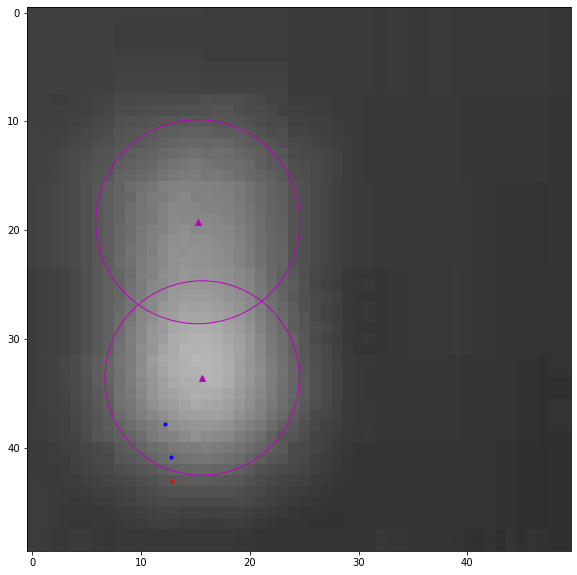

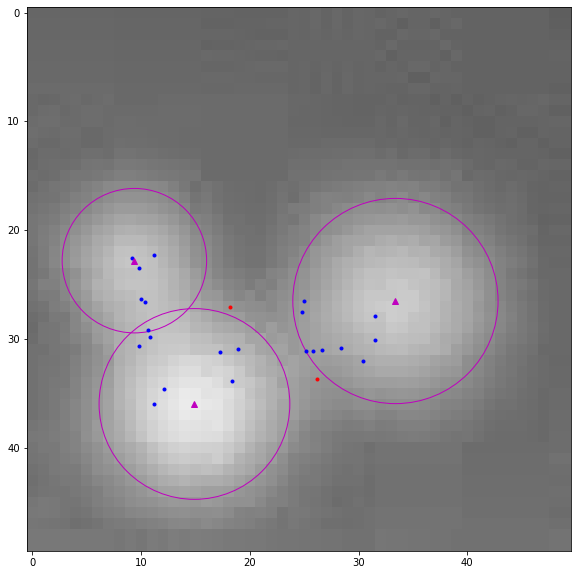

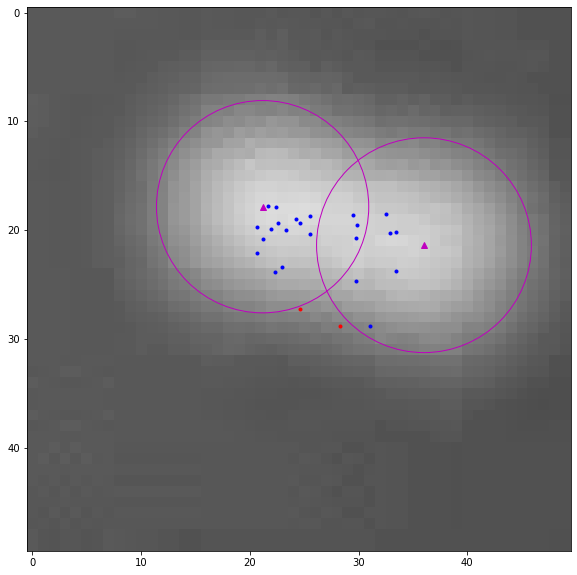

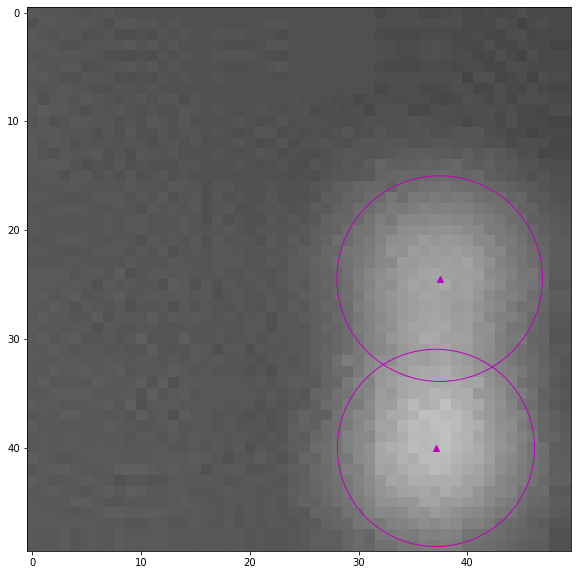

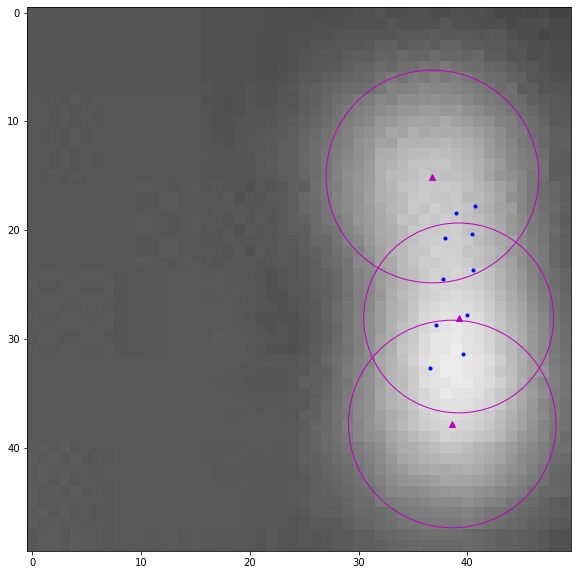

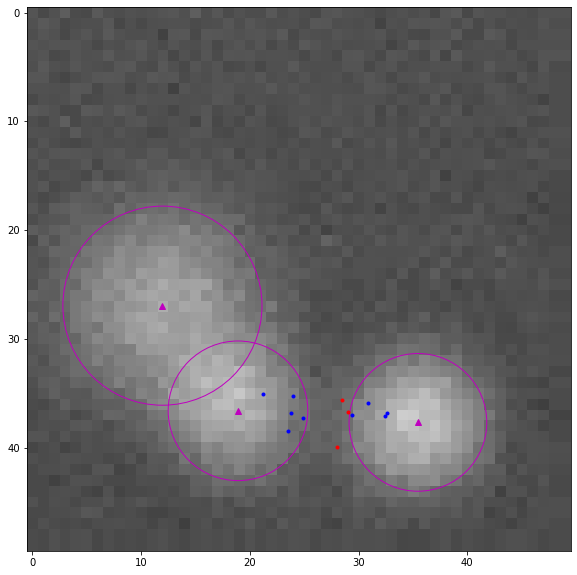

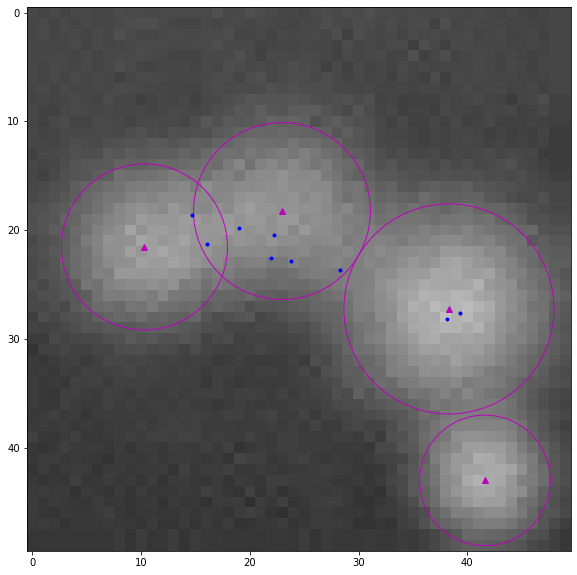

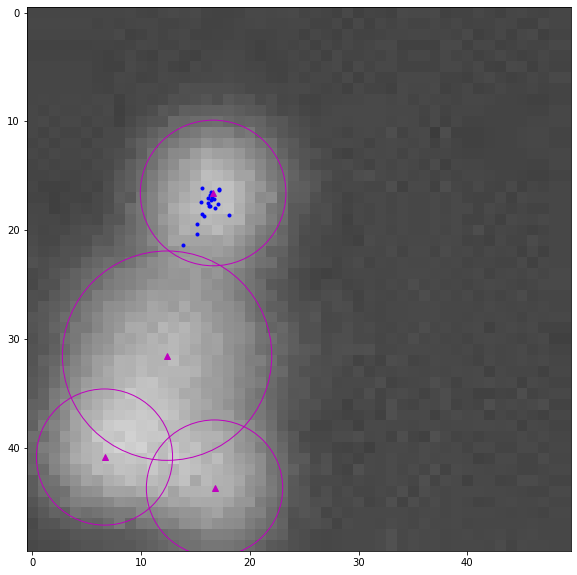

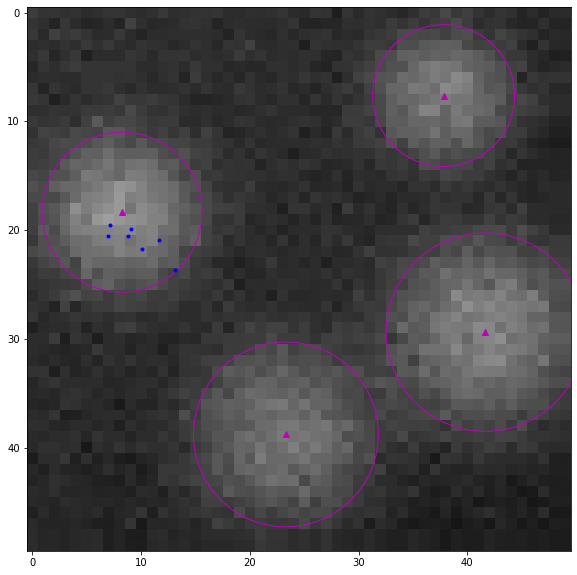

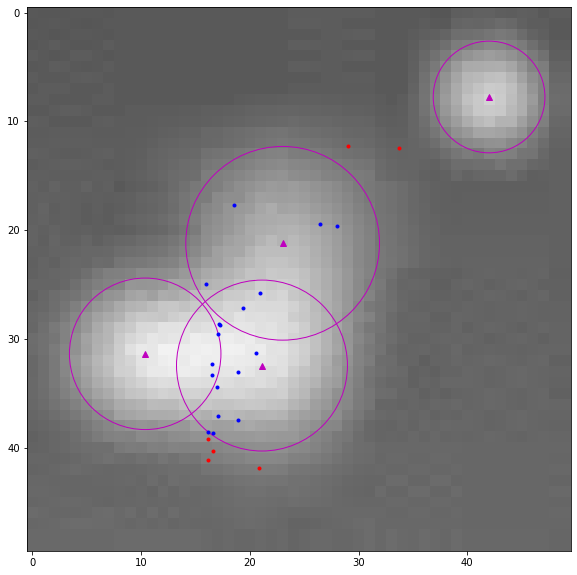

In [64]:
particle_radial_distance_threshold = 15
particle_maximum_interdistance = 30

nr_real_particles,nr_predictions,nr_hits,nr_misses,misses = benchmark.hits_and_misses_DT(number_frames_to_be_tracked,
                                                                  predicted_positions_wrt_frame,
                                                                  particle_positions_and_radiuses,
                                                                  particle_radial_distance_threshold,
                                                                  return_misses = True)

benchmark.visualize_hits_and_misses_DT(number_frames_to_be_tracked,
                          frames, 
                          particle_positions_and_radiuses,
                          predicted_positions_wrt_frame,
                          particle_radial_distance_threshold,
                          misses)
                    

## Predict using our version

In [65]:
def get_predicted_positions_unet(number_frames_to_be_tracked, batch_predictions,video_width, video_height, cutoff_value = 0.9):
    import imageGeneration as IG
    predicted_positions = []
    predictions = IG.cutoff(batch_predictions,cutoff_value, apply_sigmoid=True)

    for i in range(number_frames_to_be_tracked):

        (x_mean_list, y_mean_list, r_mean_list, i_mean_list) = IG.get_particle_centers(predictions[i])

        for j in range(len(x_mean_list)):
            x_position = x_mean_list[j]
            y_position = y_mean_list[j]
            frame_index = i
            if(x_position <= video_width and y_position <= video_height):
                predicted_positions.append((frame_index,x_position,y_position))
    
    return predicted_positions

2.0
1.0
1.0
0.0
[]


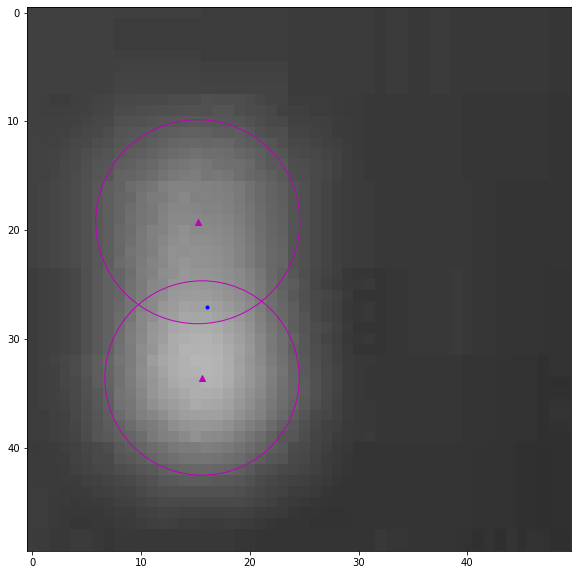

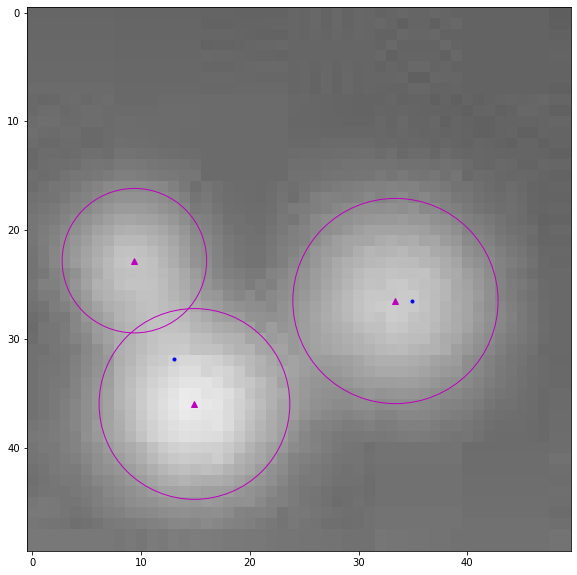

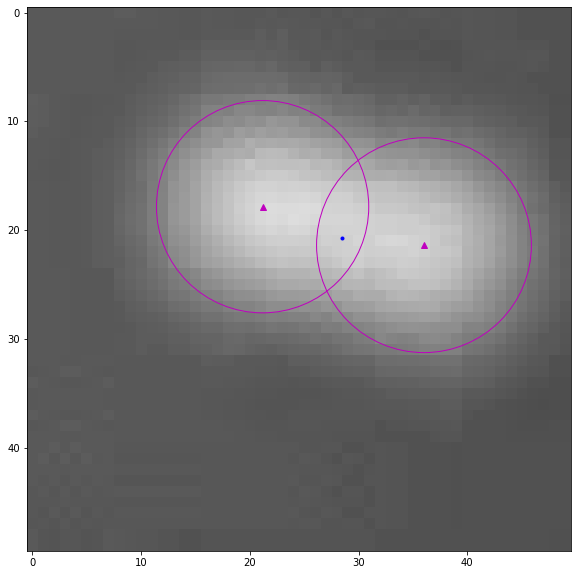

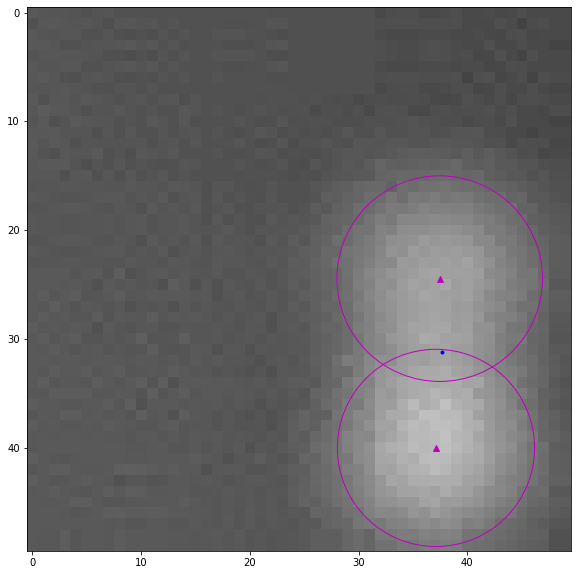

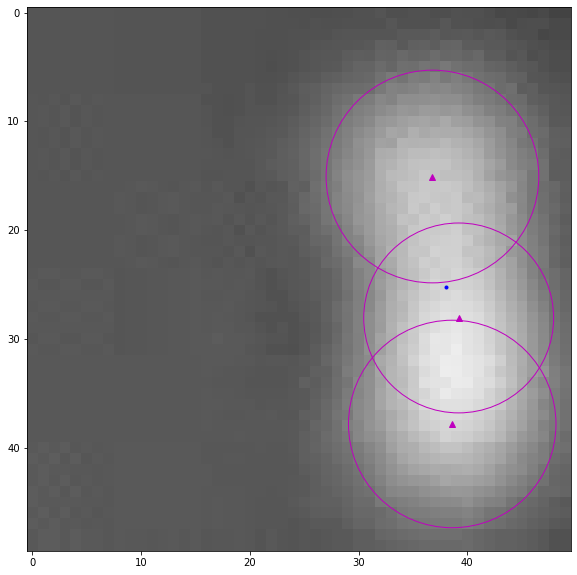

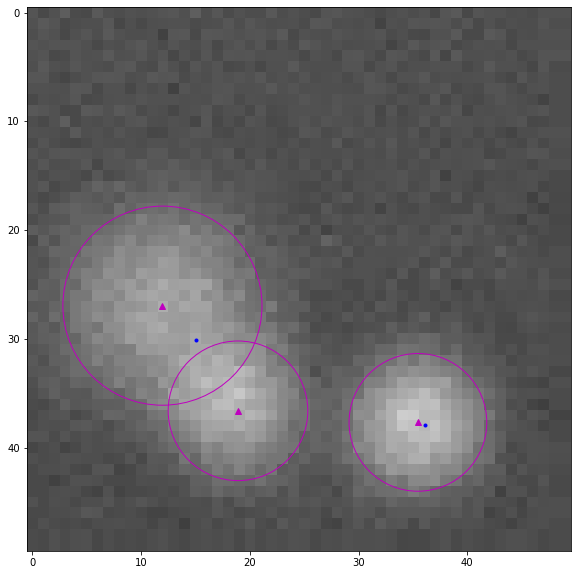

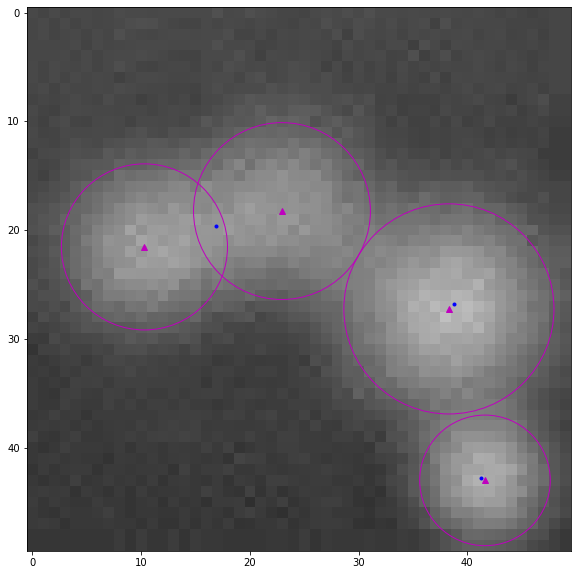

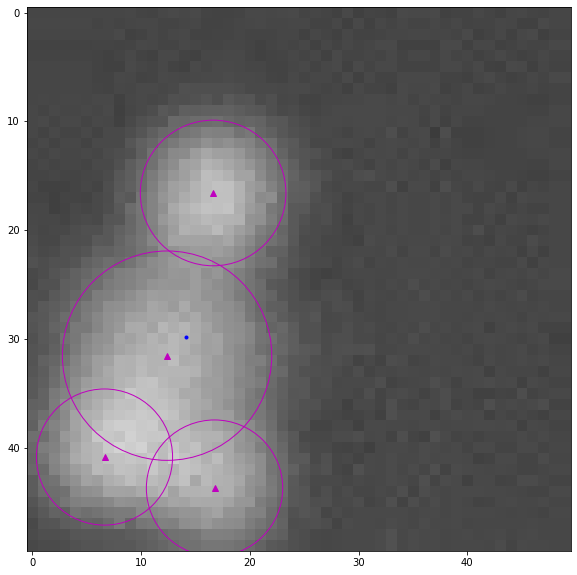

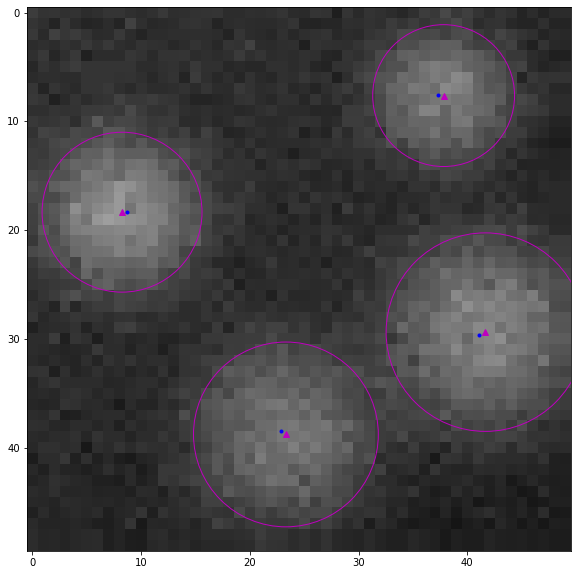

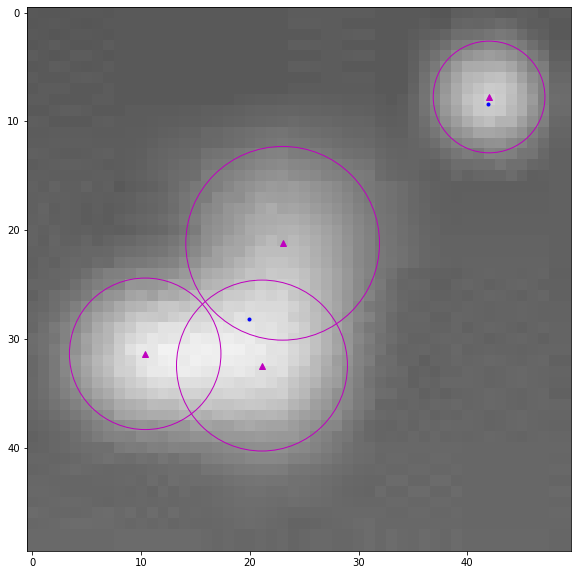

In [66]:

video = cv2.VideoCapture("output.mp4")
number_frames_to_be_tracked = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

batch_images = np.zeros((number_frames_to_be_tracked,video_height,video_width,1))


for i in range(number_frames_to_be_tracked):
    (ret, frame) = video.read()
    batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")
batch_predictions = unet.predict(model,batch_images)

batch = (unet.get_padded_images(batch_images),batch_labels,batch_predictions)


predicted_positions = get_predicted_positions_unet(number_frames_to_be_tracked, batch_predictions,video_width, video_height)

nr_real_particles,nr_predictions,nr_hits,nr_misses,misses = hits_and_misses(number_frames_to_be_tracked,
                               predicted_positions,
                               particle_positions_and_radiuses,
                               return_misses = True)

visualize_hits_and_misses(number_frames_to_be_tracked,
                               frames,
                               particle_positions_and_radiuses,
                               predicted_positions,
                               misses)
print(nr_real_particles[0])
print(nr_predictions[0])
print(nr_hits[0])
print(nr_misses[0])
print(misses)



## Predictions side by side

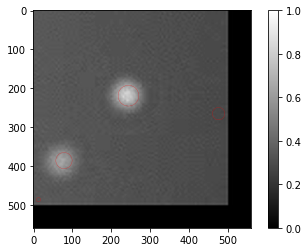

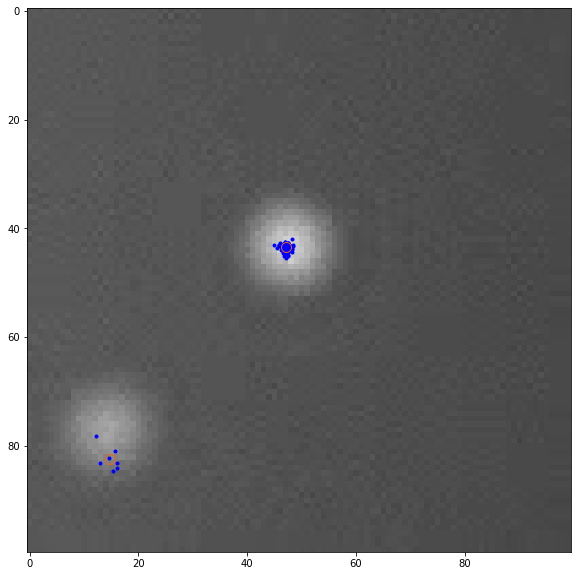

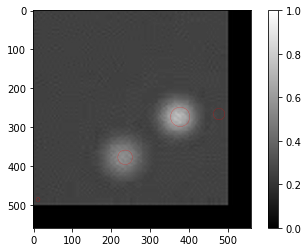

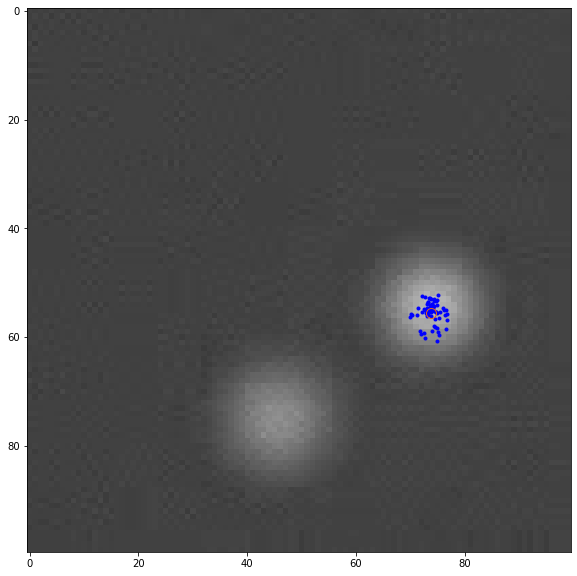

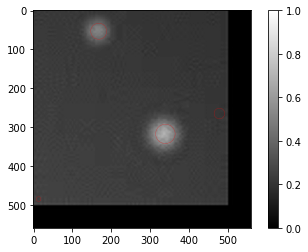

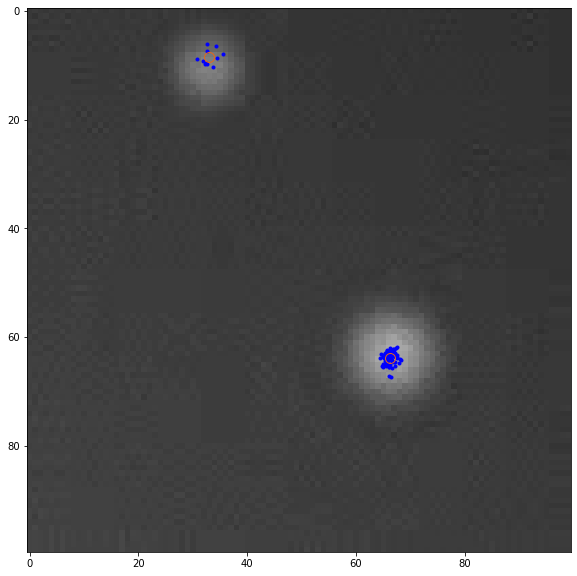

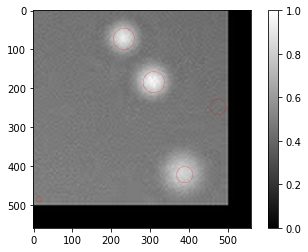

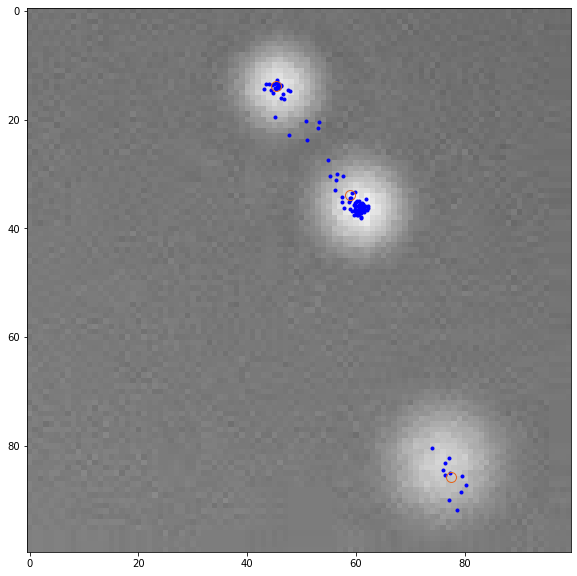

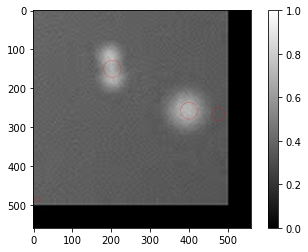

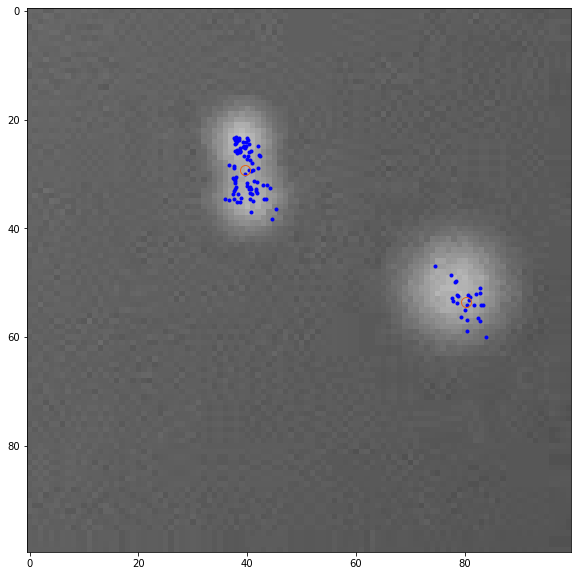

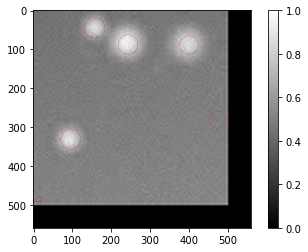

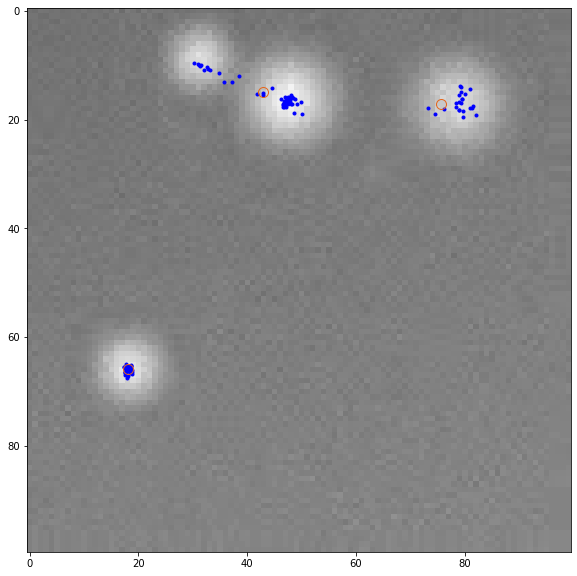

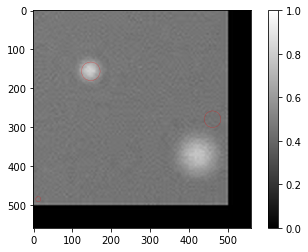

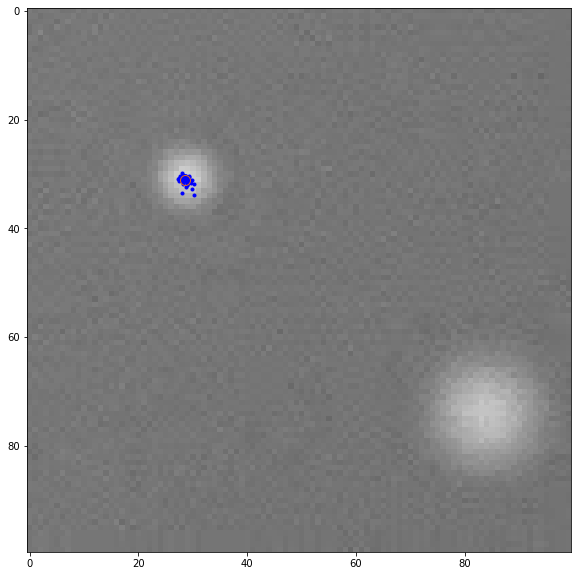

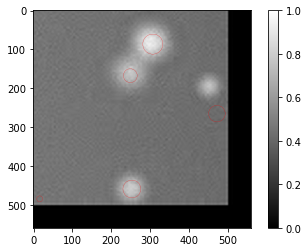

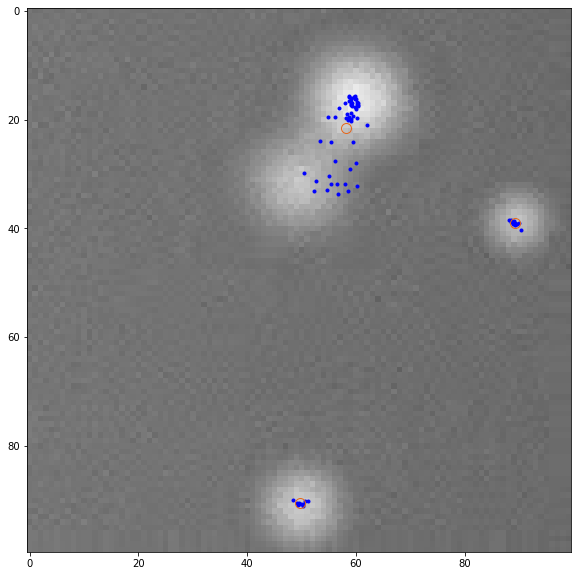

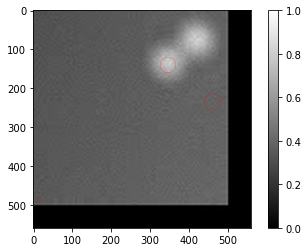

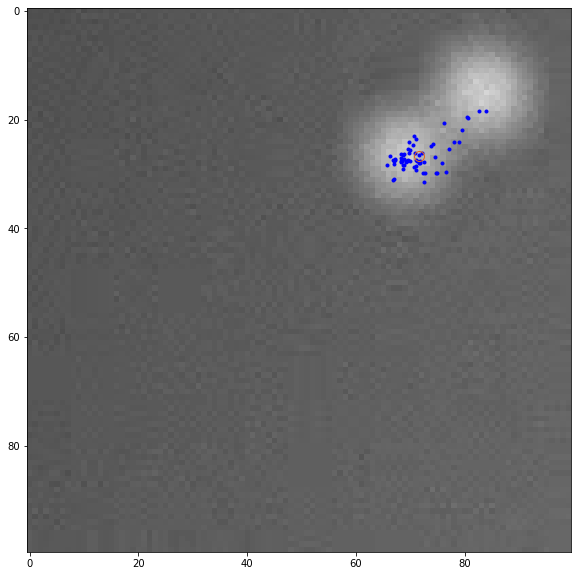

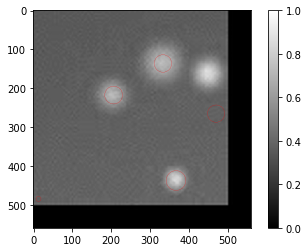

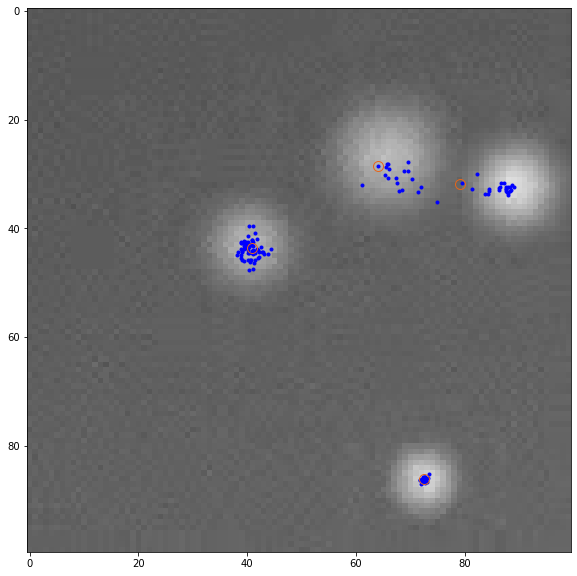

In [34]:
#TODO: få bilderna att visas sida vid sida elr åtminstone i samma/rimlig storlek



video = cv2.VideoCapture("output.mp4")

saved_network_file_name = "DeepTrack - Example 3 - Pretrained network.h5"
dt_model = DT.load(saved_network_file_name)
(number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
 boxes_all) = DT.track_video("output.mp4", dt_model,box_half_size = 18,box_scanning_step = 3,frame_normalize = 0,frame_enhance = 1,number_frames_to_be_tracked = 0)

particle_radial_distance_threshold = 15

### Define the minumum distance between predicted scanning points for them belonging to the same particle
particle_maximum_interdistance = 24



number_frames_to_be_tracked = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

batch_images = np.zeros((number_frames_to_be_tracked,video_height,video_width,1))

for i in range(number_frames_to_be_tracked):
    (ret, frame) = video.read()
    batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")
batch_predictions = unet.predict(model,batch_images)

batch = (unet.get_padded_images(batch_images),None,batch_predictions)

for i in range(number_frames_to_be_tracked):
    IG.visualise_batch(batch,apply_cutoff = True,cutoff_value = 0.95,index_of_image_to_show=i)
    plt.show()
    
    number_tracked_frames = 1
    frame = frames[i:i+1,:,:]
    predicted_position_wrt_frame = predicted_positions_wrt_frame[i:i+1,:,:,:]
    
    DT.show_tracked_frames(particle_radial_distance_threshold, particle_maximum_interdistance,
                       number_tracked_frames, frame, predicted_position_wrt_frame)
    plt.show()
    
    